### Imports

In [1]:
import pandas as pd
import numpy as np
import datetime
import dateutil
from datetime import timedelta
from collections import Counter
pd.set_option('display.max_columns', 500)
import ast
import re
from tqdm.notebook import tqdm, tnrange
tqdm.pandas()
import missingno as msno
import seaborn as sns
import swifter

In [2]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download('punkt')
import nltk.data
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

from transformers import T5Tokenizer, T5ForConditionalGeneration, T5Config
import torch
import json 

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/brianphelps/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# from pandarallel import pandarallel
# pandarallel.initialize(progress_bar=True)

In [4]:
'''
  GRAB MOVIE DATA FROM THREADS
'''
def createDate(row):
  if type(row)==str:
    return dateutil.parser.parse(row).strftime('%Y-%m-%d')
  else:
    return np.nan

def createDf():
  path = "./data//full_"
  paths = ['one', 'two', 'three', 'four', 'five', 'six']
  df = pd.DataFrame()
  for val in paths:
    df = df.append(pd.read_csv(f"{path}{val}.csv"))
  return df

df = createDf()

#DROP INVALID DISTRIBUTOR COLUMNS
df = df.drop(columns=['distributor'])

#DROP MOVIES WITHOUT DEPENDENT VARIABLE DATA
# df.dropna(subset=['box_office'], inplace=True)

#DROP DUPLICATE MOVIES
df = df.drop_duplicates(subset=['profile'])
df = df.reset_index(drop=True)

/Users/brianphelps/opt/anaconda3/envs/recommender/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (29) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [5]:
df.shape

(367802, 42)

In [6]:
drop_columns=['cast_members','cast_anchors','directors','mpaa','stars','prod_anchors','budget','box_office', 'int_office', 'runtime','director_credits','cinematographer','cin_anch','musician','musician_anchor', 'prod_designer', 'prod_designer_anchor','costume_designer','costume_designer_anchor','sequel','screen_writers','screen_anchors','screen_credits','spec_eff','sound_mix','producers','prod_credits','cast_count','comp_count','version_count','references_count']
df=df.drop(columns=drop_columns)

In [7]:
df.head()

,name,profile,plot,summary,sequels,pro_comp,director_anchors,release,genre,star_anchs,languages
0,Star Wars: Episode VII - The Force Awakens,/title/tt2488496/,"Luke Skywalker has vanished. In his absence, t...","Three decades after the Empire's defeat, a new...","['Star Wars: Episode IV - A New Hope', 'Star W...","['Lucasfilm', 'Bad Robot', 'Truenorth Producti...",['/name/nm0009190/'],18 December 2015,"['Action', 'Adventure', 'Sci-Fi']","['/name/nm5397459/', '/name/nm3915784/', '/nam...",English
1,Avengers: Endgame,/title/tt4154796/,"In the opening, Clint Barton is teaching his d...",After the devastating events of Avengers: Infi...,"['The Avengers', 'Avengers: Age of Ultron', 'A...",['Marvel Studios'],"['/name/nm0751577/', '/name/nm0751648/']",26 April 2019,"['Action', 'Adventure', 'Drama']","['/name/nm0000375/', '/name/nm0262635/', '/nam...",English|Japanese|Xhosa|German
2,Avatar,/title/tt0499549/,The story opens with a sweeping shot high acro...,A paraplegic Marine dispatched to the moon Pan...,NaN,"['Twentieth Century Fox', 'Dune Entertainment'...",['/name/nm0000116/'],18 December 2009,"['Action', 'Adventure', 'Fantasy']","['/name/nm0941777/', '/name/nm0757855/', '/nam...",English|Spanish
3,Black Panther,/title/tt1825683/,A voice from a young boy asks to tell him a st...,"T'Challa, heir to the hidden but advanced king...",NaN,"['Marvel Studios', 'Walt Disney Pictures']",['/name/nm3363032/'],16 February 2018,"['Action', 'Adventure', 'Sci-Fi']","['/name/nm1569276/', '/name/nm0430107/', '/nam...",English|Swahili|Nama|Xhosa|Korean
4,Avengers: Infinity War,/title/tt4154756/,SPOILER: Thanos and his Children - Proxima Mid...,The Avengers and their allies must be willing ...,"['The Avengers', 'Avengers: Age of Ultron']","['Marvel Studios', 'Jason Roberts Productions'...","['/name/nm0751577/', '/name/nm0751648/']",27 April 2018,"['Action', 'Adventure', 'Sci-Fi']","['/name/nm0000375/', '/name/nm1165110/', '/nam...",English


In [8]:
df=df.dropna(subset=['languages'])

In [9]:
df['languages']=df['languages'].progress_apply(lambda x: x if 'English' in x else np.nan)

  0%|          | 0/314537 [00:00<?, ?it/s]

In [10]:
df=df.dropna(subset=['languages'])

In [11]:
df['languages']=df['languages'].progress_apply(lambda x: x.split("|"))

  0%|          | 0/119984 [00:00<?, ?it/s]

In [12]:
df['languages']=df['languages'].progress_apply(lambda x: x[0])

  0%|          | 0/119984 [00:00<?, ?it/s]

In [13]:
df['languages']=df['languages'].progress_apply(lambda x: x if x == 'English' else np.nan)

  0%|          | 0/119984 [00:00<?, ?it/s]

In [14]:
df=df.dropna(subset=['languages'])

In [15]:
errors = ['The plot is unknown at this time.','Add a Plot\xa0»','Plot unknown.','Plot kept under wraps.','Plot is unknown.','The plot is unknown.','Plot is unknown at this time.','The plot is currently unknown.','Plot is being kept under wraps.']
replace = ['See full summary\xa0»','...\n','\n','See full summary »']

In [16]:
df=df.reset_index(drop=True)
error_count=0
keep_indices=[]
for idx,row in tqdm(enumerate(df.itertuples()),total=len(df)):
  if row.summary in errors:
    error_count+=1
  else:
    keep_indices.append(idx)
  if type(row.summary)==str:
    for val in replace:
      if val in row.summary:
        df.at[idx, 'summary']=row.summary.replace(val, "")
    

  0%|          | 0/112506 [00:00<?, ?it/s]

In [17]:
df=df.iloc[keep_indices]

In [18]:
df=df.reset_index(drop=True)

In [19]:
def mainProd(row):
  try:
    return row[0]
  except:
    return np.nan
tqdm.pandas(desc="Production Company")
df['main_prod'] = df['pro_comp'].progress_apply(lambda x: ast.literal_eval(x)[0] if type(x)==str else np.nan)
df=df.drop('pro_comp',axis=1)

Production Company:   0%|          | 0/91478 [00:00<?, ?it/s]

In [20]:
lists = ['sequels','director_anchors','star_anchs']
for val in lists:
  df[val]=df[val].apply(lambda x: ast.literal_eval(x) if type(x)==str else np.nan)

In [21]:
fixed_plots = []
for idx, row in enumerate(df.itertuples()):
  if type(row.summary)!=str:
    if type(row.plot)==str:
      df.at[idx, 'summary']=row.plot
      fixed_plots.append(row.plot)

In [22]:
print(f"Fixed {len(fixed_plots)} movie summaries")

Fixed 0 movie summaries


In [23]:
df=df.dropna(subset=['summary'])
df=df.reset_index(drop=True)

In [24]:
df=df.dropna(subset=['director_anchors','genre','star_anchs'])

<AxesSubplot:>

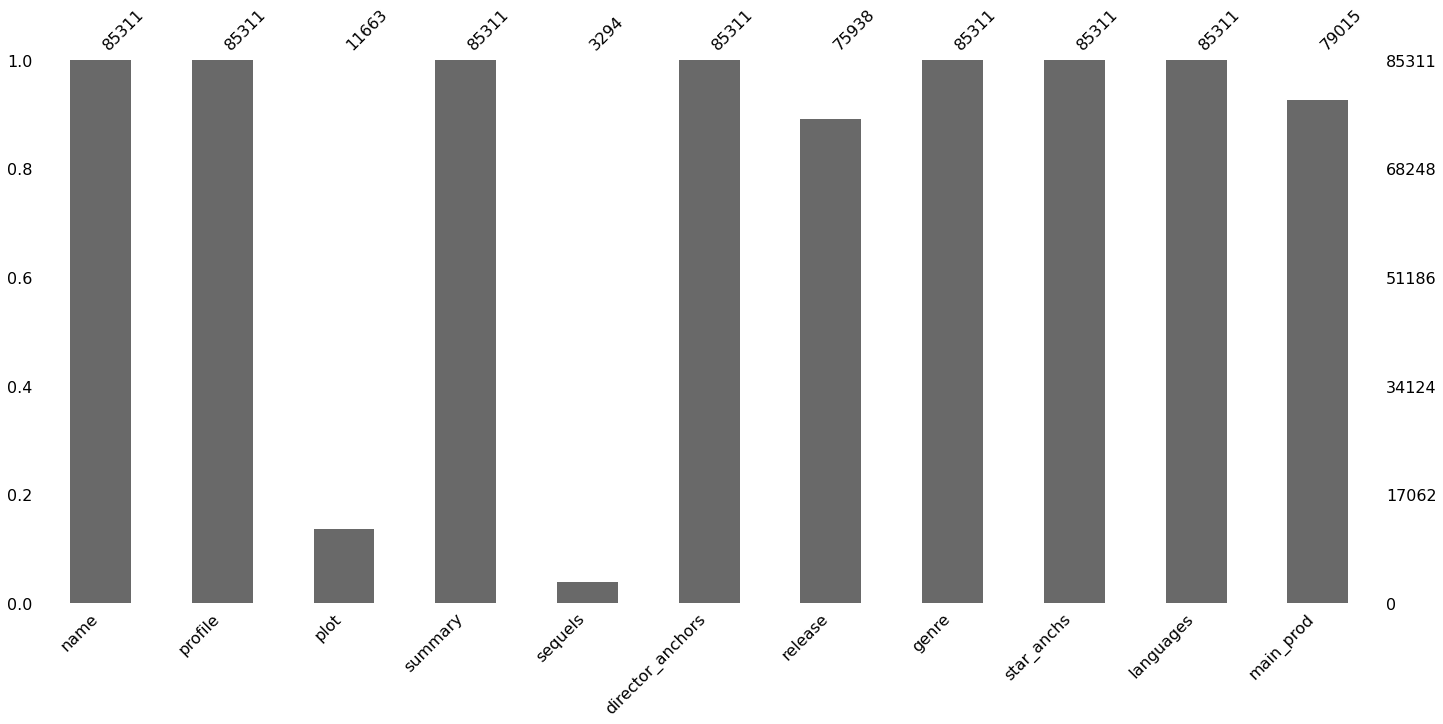

In [25]:
msno.bar(df)

In [27]:
df=df[['name','profile','summary','director_anchors','release','genre','star_anchs','main_prod']]

In [28]:
df=df.reset_index(drop=True)

### Feature Engineering

#### Genre and Director
#### Genre and Stars
#### Stars and Director
#### Stars Director Genre

In [29]:
def summary_len(text):
  result = len(tokenizer.tokenize(text))
  return result
tqdm.pandas(desc="Summary Length")
df['summary_len']=df['summary'].progress_apply(summary_len)

Summary Length:   0%|          | 0/85311 [00:00<?, ?it/s]

<AxesSubplot:xlabel='summary_len'>

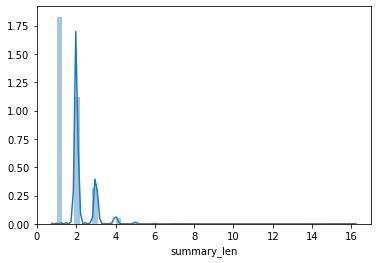

In [30]:
sns.distplot(df['summary_len'])

In [31]:
tqdm.pandas(desc="Word Count")
df['word_count']=df['summary'].progress_apply(lambda x: len(x.split(" ")))

Word Count:   0%|          | 0/85311 [00:00<?, ?it/s]

In [32]:
len(df.loc[df['word_count']<30])

38338

<AxesSubplot:xlabel='word_count'>

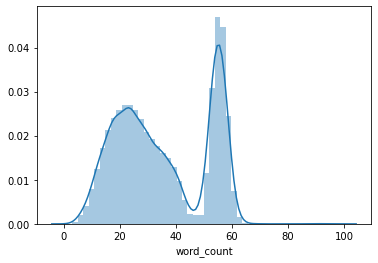

In [33]:
sns.distplot(df['word_count'])

In [34]:
np.bincount(df['summary_len'])

array([    0, 46776, 28624,  8209,  1326,   270,    65,    26,     9,
           3,     1,     0,     1,     0,     0,     0,     1])

In [35]:
from transformers import AlbertTokenizer, AlbertForPreTraining
import torch

tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
model = AlbertForPreTraining.from_pretrained('albert-base-v2')

Some weights of AlbertForPreTraining were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['sop_classifier.classifier.weight', 'sop_classifier.classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
df['summary_tokens'] = tokenizer.batch_encode_plus(df['summary'],max_length=30,truncation=True,padding=True).input_ids

In [ ]:
df.to_csv("data.csv")

In [ ]:
count = CountVectorizer()
count_matrix = count.fit_transform(df['bag_of_words'])

# generating the cosine similarity matrix
cosine_sim = cosine_similarity(count_matrix, count_matrix)